In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import re
import json
import transformers

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# %%
# pragma: no-run
import json
data_path = "/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json"
with open(data_path) as file:
    lines = file.readlines()
    # print(lines[0])   # str形式的dict

paper_item = json.loads(lines[0])
for key, value in paper_item.items():
    print(key+" : ", value)

id :  0704.0001
submitter :  Pavel Nadolsky
authors :  C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan
title :  Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
comments :  37 pages, 15 figures; published version
journal-ref :  Phys.Rev.D76:013009,2007
doi :  10.1103/PhysRevD.76.013009
report-no :  ANL-HEP-PR-07-12
categories :  hep-ph
license :  None
abstract :    A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for

# table
id | title | authors |categories | abs | date| ...(citation)|

In [3]:
# %%
# pragma: no-run
papers = []
for line in lines:
    papers.append(json.loads(line))
papers = pd.DataFrame(papers)
papers = papers.drop(columns=["comments","journal-ref","doi","report-no", "license"])
papers.head()

,id,submitter,authors,title,categories,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [4]:
# %%
# pragma: no-run
# len(papers)   # 2370685
import re
pattern = r"(^|\s)cs\."  # 匹配 "由cs.开头或\space cs. "的模式
matches = papers["categories"].str.match(pattern, na=False)

cs_papers = papers[matches]  # len() 462764
cs_papers["categories"].unique()

array(['cs.NE cs.AI', 'cs.DS',
       'cs.CE cond-mat.stat-mech cs.MS cs.NA physics.data-an', ...,
       'cs.IR cs.CC cs.DL', 'cs.MA adap-org cs.NI nlin.AO',
       'cs.DC adap-org cs.MA cs.NI nlin.AO'], dtype=object)

In [5]:
# %%
# pragma: no-run
cs_papers_path = "/kaggle/working/cs_papers.json"
if not os.path.exists(cs_papers_path):
    cs_papers.to_json(cs_papers_path)

## 考虑利用title和categories训练一个多分类器

### TF-IDF 表示标题特征
(462764, 101910)
TF-IDF生成的矩阵维数太高了，不太行。。。
> 后期可以考虑tokenizer + embbeding 表示为向量
### 训练一个多分类器

In [6]:
# %%
# pragma: no-run
# 需要去除categories中非cs的标签
# 首先将categories 字符串分割，只保留cs标签
# 构建 (id) tittle : ["cs.label1", "cs.label2"]
cs_papers_path = "/kaggle/working/cs_papers.json"
if cs_papers is None:
    with open(cs_papers_path, "r") as f:
        cs_papers = pd.DataFrame(json.load(f))
        
for index, row in cs_papers.iterrows():
    words = row["categories"].split()
    processed_words = [word for word in words if word.startswith('cs.')]
    
    cs_papers.at[index, "categories"] = processed_words

cs_papers.head()

,id,submitter,authors,title,categories,abstract,versions,update_date,authors_parsed
46,0704.0047,Igor Grabec,T. Kosel and I. Grabec,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]",The intelligent acoustic emission locator is...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2009-09-29,"[[Kosel, T., ], [Grabec, I., ]]"
49,0704.0050,Igor Grabec,T. Kosel and I. Grabec,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]",Part I describes an intelligent acoustic emi...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2007-05-23,"[[Kosel, T., ], [Grabec, I., ]]"
61,0704.0062,Tom\'a\v{s} Vina\v{r},"Rastislav \v{S}r\'amek, Bro\v{n}a Brejov\'a, T...",On-line Viterbi Algorithm and Its Relationship...,[cs.DS],"In this paper, we introduce the on-line Vite...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2010-01-25,"[[Šrámek, Rastislav, ], [Brejová, Broňa, ], [V..."
89,0704.0090,Lester Ingber,Lester Ingber,Real Options for Project Schedules (ROPS),"[cs.CE, cs.MS, cs.NA]",Real Options for Project Schedules (ROPS) ha...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2007-05-23,"[[Ingber, Lester, ]]"
97,0704.0098,Jack Raymond,"Jack Raymond, David Saad",Sparsely-spread CDMA - a statistical mechanics...,[cs.IT],"Sparse Code Division Multiple Access (CDMA),...","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2009-11-13,"[[Raymond, Jack, ], [Saad, David, ]]"


In [7]:
# %%
# pragma: no-run
title_categories = cs_papers[["title", "categories"]]
title_categories.head()


,title,categories
46,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]"
49,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]"
61,On-line Viterbi Algorithm and Its Relationship...,[cs.DS]
89,Real Options for Project Schedules (ROPS),"[cs.CE, cs.MS, cs.NA]"
97,Sparsely-spread CDMA - a statistical mechanics...,[cs.IT]


In [8]:
# %%
# pragma: no-run
title_abs_categories = cs_papers[["title", "abstract","categories"]]
title_abs_categories.head()

,title,abstract,categories
46,Intelligent location of simultaneously active ...,The intelligent acoustic emission locator is...,"[cs.NE, cs.AI]"
49,Intelligent location of simultaneously active ...,Part I describes an intelligent acoustic emi...,"[cs.NE, cs.AI]"
61,On-line Viterbi Algorithm and Its Relationship...,"In this paper, we introduce the on-line Vite...",[cs.DS]
89,Real Options for Project Schedules (ROPS),Real Options for Project Schedules (ROPS) ha...,"[cs.CE, cs.MS, cs.NA]"
97,Sparsely-spread CDMA - a statistical mechanics...,"Sparse Code Division Multiple Access (CDMA),...",[cs.IT]


In [9]:
# %%
# pragma: no-run
title_categories_path = "/kaggle/working/title_categories.json"
title_abs_categories_path = "/kaggle/working/title_abs_categories.json"
if not os.path.exists(title_abs_categories_path):
    title_abs_categories.to_json(title_abs_categories_path)
if not os.path.exists(title_categories_path):
    title_categories.to_json(title_categories_path)

# 从这里开始title-categories的分类

In [10]:
title_categories_path = "/kaggle/input/mydatasets/title_categories.json"

with open(title_categories_path, "r") as f:
    title_categories = pd.DataFrame(json.load(f))
title_categories.head()

,title,categories
46,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]"
49,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]"
61,On-line Viterbi Algorithm and Its Relationship...,[cs.DS]
89,Real Options for Project Schedules (ROPS),"[cs.CE, cs.MS, cs.NA]"
97,Sparsely-spread CDMA - a statistical mechanics...,[cs.IT]


{2: 136602, 1: 276364, 3: 40881, 4: 7712, 5: 1174, 7: 3, 6: 28}


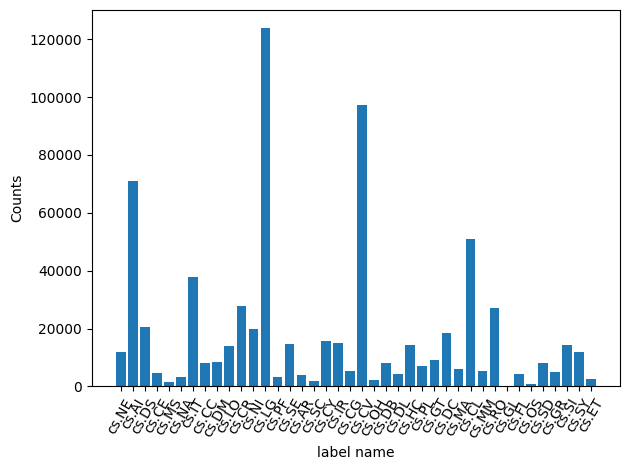

In [11]:
labels_counts = {}
multi_label_counts = {}
for labels in title_categories["categories"]:
    multi_label_counts[len(labels)] = multi_label_counts.get(len(labels), 0) + 1
    for label in labels:
        labels_counts[label] = labels_counts.get(label, 0) + 1

print(multi_label_counts)
# 40 类
plt.bar(list(labels_counts.keys()), list(labels_counts.values()))
plt.xticks(rotation=60)
plt.xlabel("label name")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()


## multi_label_counts：
- num_labels : counts
- 1 :  276364
- 2 :  136602
- 3 :  40881
- 4 :  7712
- 5 :  1174
- 6 :  28
- 7 :  3

绝大多数的paper的label个数在5个以内，大多数在3个以内。

In [12]:
max_length = 0
for title in title_categories["title"]:
    length = len(title.split())
    if length > max_length:
        max_length = length
max_length   # 37

37

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
multilabels = MultiLabelBinarizer()
# 转换成k-hot形式的multi-labels
y_multilabels = multilabels.fit_transform(title_categories["categories"].values)
print(y_multilabels.shape)    #(462764, 40)
print(y_multilabels[:5])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(462764, 40)
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]


In [14]:
# Load model directly
from transformers import BertModel,BertTokenizer
bert_model = BertModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2")

In [15]:
out = tokenizer.batch_encode_plus(title_categories["title"].to_list(), max_length=48,
                                  padding="max_length", truncation=True)
print(out.keys())
input_ids = np.array(out['input_ids'])
attention_masks = np.array(out['attention_mask'])


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [16]:
class MyDataSet(Dataset):
    def __init__(self, X, masks, y) -> None:
        super().__init__()
        self.X = torch.from_numpy(X).int()
        self.masks = torch.from_numpy(masks).int()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.masks[index], self.y[index]

In [17]:
class MyClassifier(nn.Module):
    def __init__(self, num_hidden, num_class):
        super().__init__()
        self.bert = bert_model    # 仅作embedding，
        for param in self.bert.parameters():
            param.requires_grad = True
        
        # k cnn-filters k(out_channels)->32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 128)) # out= in - kernel_size + 1
        self.conv2 = nn.Conv2d(1, 32, kernel_size=(5, 128))
        self.conv3 = nn.Conv2d(1, 32, kernel_size=(7, 128))
        # N,C_out,
        self.pooling = nn.MaxPool2d((3,1), (3,1))
        self.fc1 = nn.Linear(32*44, num_hidden)
        self.sig1 = nn.Sigmoid()
        self.fc2 = nn.Linear(num_hidden, num_class)
        #self.sig2 = nn.Sigmoid()
  
    def forward(self, x, mask):
        # 取bert最后一层隐状态
        out = self.bert(x, attention_mask=mask, token_type_ids=None,)
        last_hidden_state = out["last_hidden_state"]  # N, 48, 128
        #print(hidden_states.shape)
        last_hidden_state.unsqueeze_(1)  # N, 1, 48, 128
        
        out1 = self.conv1(last_hidden_state)  # 48 - 3 + 1
        out2 = self.conv2(last_hidden_state)
        out3 = self.conv3(last_hidden_state)
        out = torch.cat([out1, out2, out3], dim=2)  # N, 32, (46 + 44 + 42 = 132), 1
        out = self.pooling(out)  # N, 32, 44, 1
        #print(out.shape)
        out = out.reshape(out.shape[0], -1)
        #print(out.shape)
        out = self.sig1(self.fc1(out))
        out = self.fc2(out)
        
        #print(out.shape)
        return out
        

In [18]:
test_radio = 0.2
batch_size = 128
# [:25600]
X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(input_ids[:25600], attention_masks[:25600], y_multilabels[:25600], test_size=test_radio, random_state=49)
train_dataset, val_dataset = MyDataSet(X_train, mask_train, y_train), MyDataSet(X_val, mask_val, y_val)
train_loader, val_loader = DataLoader(train_dataset, batch_size, shuffle=True), DataLoader(val_dataset, batch_size)

In [19]:
from transformers import get_scheduler
model = MyClassifier(num_hidden=512 ,num_class=40)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.AdamW(model.parameters(), lr=5e-5) #fine-tuning bert
criterion = nn.BCEWithLogitsLoss()
num_epochs = 30
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, 
    num_training_steps=num_training_steps)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

MyClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine

In [20]:

def precision_k(predicts, labels, k=3):
    """
    predicts : (batch_size, C)
    labels : (batch_size, C)  {0, 1}^C
    """
    predicts, labels = predicts.to(device), labels.to(device)
    _, topk_pred_ids = predicts.topk(k, dim=1)  # batch_size, k

    precision_rank_k = torch.zeros(labels.shape[0]).to(device) # batch_size,
    
    for pred_ids in topk_pred_ids.T:
        precision_rank_k += labels[torch.arange(labels.shape[0]), pred_ids]
        
    return precision_rank_k / k

def eval(net, top_k:list, val_loader, metric=precision_k):
    net.eval()
    correct_topk = torch.zeros(len(top_k))
    with torch.no_grad():
        for x, mask, y in val_loader:
            x, mask = x.to(device), mask.to(device)
            outputs = net(x, mask)
            for i, k in enumerate(top_k):
                correct_topk[i] += metric(outputs, y, k).mean().item()
    
    return correct_topk / len(val_loader)

In [21]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

top_k = [1, 2, 3]
log_num = 2
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for x, mask, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x.to(device), mask.to(device))
        loss = criterion(outputs.to(device), y.to(device))
        #with torch.autograd.set_detect_anomaly(True):
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        lr_scheduler.step()
        
        progress_bar.update(1)
    if (epoch + 1)% log_num == 0:
        print(f"[Train]: {epoch + 1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")
    
        precisions = eval(model, top_k, val_loader=val_loader)
        for i, k in enumerate(top_k):    
            print(f"P@{k}={precisions[i].item()*100:.4f}%")



  0%|          | 0/4800 [00:00<?, ?it/s]

[Train]: 2/30, Loss: 0.14780437918379902
P@1=21.7773%
P@2=15.8008%
P@3=13.9648%
[Train]: 4/30, Loss: 0.13504500901326538
P@1=21.7773%
P@2=15.8008%
P@3=13.9648%
[Train]: 6/30, Loss: 0.13395923832431436
P@1=21.7773%
P@2=16.0352%
P@3=13.9648%
[Train]: 8/30, Loss: 0.13360807290300727
P@1=21.7773%
P@2=15.8008%
P@3=13.9648%
[Train]: 10/30, Loss: 0.11979669546708464
P@1=37.0898%
P@2=26.3281%
P@3=21.1198%
[Train]: 12/30, Loss: 0.10989140807650984
P@1=39.8242%
P@2=28.5840%
P@3=23.0208%
[Train]: 14/30, Loss: 0.10484679122455418
P@1=42.8516%
P@2=30.6543%
P@3=24.2122%
[Train]: 16/30, Loss: 0.10029046121053398
P@1=45.8594%
P@2=31.9824%
P@3=25.1953%
[Train]: 18/30, Loss: 0.09649797328747808
P@1=48.4570%
P@2=33.6914%
P@3=26.4909%
[Train]: 20/30, Loss: 0.09311681580729783
P@1=50.6641%
P@2=34.9414%
P@3=27.3437%
[Train]: 22/30, Loss: 0.0905111865606159
P@1=52.7734%
P@2=35.6934%
P@3=27.9622%
[Train]: 24/30, Loss: 0.08842056388966739
P@1=53.2812%
P@2=36.3184%
P@3=28.3919%
[Train]: 26/30, Loss: 0.087234988